## The PDE example

The PDE equation is:

$$\frac{\partial \phi}{\partial t}=-u\frac{\partial \phi}{\partial x}$$

With the initial value:
$$\phi_0 = \phi(x,0)$$

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# tf.compat.v1.disable_eager_execution()

# 1. Build model

## Model
https://weikaiwei.com/tf/tensorflow-2-mnist-2/

In [12]:
class solve_PDE_Model():
    def __init__(self, loss_calculator):
        self.loss_calculator = loss_calculator
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        self.metrics = tf.keras.metrics.Mean(0.001)

        inputs = tf.keras.Input(shape=(2,), name="inputs")
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer1')(inputs)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer2')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer3')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer4')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer5')(x)
        outputs = tf.keras.layers.Dense(units=1, name='output')(x)
    
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
            

    def predict(self, x_data, t_data):
        print("Start prediction")
        input_data = tf.stack([tf.reshape(x_data, [-1]), tf.reshape(t_data, [-1])], axis=1)
        return self.model(input_data)

    def train(self, x_data, t_data, epochs):
        print("Start training")
        self.metrics.reset_states()

        for epoch in range(epochs):
            self.train_epoch(x_data, t_data)

            if(epoch%500 == 0):
                print("Epoch {0}, Loss {1}".format(epoch, self.metrics.result()))

    @tf.function
    def train_epoch(self, x_data, t_data):
        with tf.GradientTape() as tape:
            x_data_reshape = tf.reshape(x_data, [-1])
            t_data_reshape = tf.reshape(t_data, [-1])
            input_data = tf.stack([x_data_reshape, t_data_reshape], axis=1)

            # Run forward
            phi = self.model(input_data)
            # Compute the loss value
            loss = self.loss_calculator.loss(x_data_reshape, t_data_reshape, phi)


        # Update metrics
        self.metrics.update_state(loss)

        # Compute gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        #Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [13]:
class PDE_Loss():
    def __init__(self, phi_init, u, regularization_factor=0.1):
        self.phi_init = phi_init
        self.u = u

    def loss(self, x_data, t_data, phi):
        phi_t = tf.gradients(phi, t_data)[0]
        phi_x = tf.gradients(phi, x_data)[0]

        phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        governing_Eq = phi_t+self.u+phi_x
        
        init_size = self.phi_init.shape[0]

        number_of_time_step = governing_Eq.shape[0] / init_size

        loss = tf.reduce_mean(tf.square(phi[:init_size]-self.phi_init)) 

        for one_time_step in range(1, int(number_of_time_step)):
                    
            loss += tf.reduce_sum(tf.square(
                # governing_Eq in loss   
                governing_Eq[one_time_step*init_size+1:(one_time_step+1)*init_size-1]
            ))
    
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[one_time_step*init_size][0]-1.0) 
            ))
        
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[(one_time_step+1)*init_size-1][0]-1.0)
            ))
                

        return loss
    


In [22]:
lx = 2
nx = 20
dx = lx / (nx-1)

lt = 0.04
nt = 4
dt = lt / (nt-1)

u = 1      #assume wavespeed of u = 1

x_line = tf.linspace(0.0, lx, nx, name="x")
t_line = tf.linspace(0.0, lt, nt, name="t")
x_init = tf.identity(x_line, name="x_init")
x, t = tf.meshgrid(x_line, t_line)

# sine wave init
np_phi_init = np.ones(nx)
sine_wave = np.linspace(0,2*np.pi, int(1.5 / dx + 1) - int(.5 / dx) )
np_phi_init[int(.5 / dx):int(1.5 / dx + 1)] += np.sin(sine_wave)
phi_init = tf.convert_to_tensor(np_phi_init, dtype=tf.float32, name="phi_init")
phi_init = tf.reshape(phi_init, [phi_init.shape[0],1])

loss_calculator = PDE_Loss(phi_init,u)
myModel = solve_PDE_Model(loss_calculator)
myModel.train(x, t, 50000)


Start training
Epoch 0, Loss 59.22814178466797
Epoch 500, Loss 3.2438652515411377
Epoch 1000, Loss 1.7490025758743286
Epoch 1500, Loss 1.2498905658721924
Epoch 2000, Loss 1.0001225471496582
Epoch 2500, Loss 0.8501670360565186
Epoch 3000, Loss 0.7501682639122009
Epoch 3500, Loss 0.6787611246109009
Epoch 4000, Loss 0.625210702419281
Epoch 4500, Loss 0.584665834903717
Epoch 5000, Loss 0.5510385632514954
Epoch 5500, Loss 0.5234556794166565
Epoch 6000, Loss 0.5004644989967346
Epoch 6500, Loss 0.4808639585971832
Epoch 7000, Loss 0.46378910541534424
Epoch 7500, Loss 0.4480690658092499
Epoch 8000, Loss 0.43350812792778015
Epoch 8500, Loss 0.4183400571346283
Epoch 9000, Loss 0.403123140335083
Epoch 9500, Loss 0.38767558336257935
Epoch 10000, Loss 0.373687207698822
Epoch 10500, Loss 0.3607006072998047
Epoch 11000, Loss 0.34887194633483887
Epoch 11500, Loss 0.3376239240169525
Epoch 12000, Loss 0.3271849453449249
Epoch 12500, Loss 0.3170713186264038
Epoch 13000, Loss 0.3073335289955139
Epoch 13500

In [25]:
result = myModel.predict(x, t)
print(result)

Start prediction
tf.Tensor(
[[ 1.0033954 ]
 [ 0.98515797]
 [ 0.963099  ]
 [ 0.9450631 ]
 [ 1.012461  ]
 [ 1.5535076 ]
 [ 1.9687326 ]
 [ 1.8913046 ]
 [ 1.5756705 ]
 [ 0.9876011 ]
 [ 0.37174857]
 [ 0.04830658]
 [ 0.02109037]
 [ 0.39104533]
 [ 0.9579196 ]
 [ 1.0010964 ]
 [ 0.9991194 ]
 [ 0.9991342 ]
 [ 1.0026171 ]
 [ 1.009156  ]
 [ 0.99211615]
 [ 0.97433233]
 [ 0.9526577 ]
 [ 0.93265086]
 [ 0.9759582 ]
 [ 1.44245   ]
 [ 1.9423457 ]
 [ 1.9005606 ]
 [ 1.6177046 ]
 [ 1.0594643 ]
 [ 0.4234723 ]
 [ 0.05813892]
 [-0.00420018]
 [ 0.286681  ]
 [ 0.92013067]
 [ 0.9874563 ]
 [ 0.9860019 ]
 [ 0.98557436]
 [ 0.9886439 ]
 [ 0.9948314 ]
 [ 0.98077977]
 [ 0.9634355 ]
 [ 0.9422015 ]
 [ 0.92090535]
 [ 0.94597304]
 [ 1.333501  ]
 [ 1.9070344 ]
 [ 1.9064324 ]
 [ 1.6549016 ]
 [ 1.1296707 ]
 [ 0.48025203]
 [ 0.07282762]
 [-0.02472879]
 [ 0.19935372]
 [ 0.87117267]
 [ 0.97332186]
 [ 0.9729242 ]
 [ 0.9720665 ]
 [ 0.9747149 ]
 [ 0.9805431 ]
 [ 0.9693912 ]
 [ 0.9524713 ]
 [ 0.931715  ]
 [ 0.90963876]
 [ 0.9210511

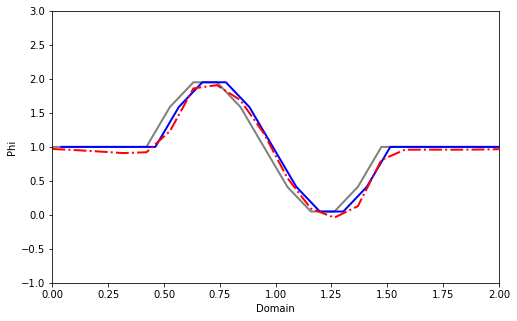

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
ax1.set_xlim((0, 2))            
ax1.set_ylim((-1, 3))
ax1.set_xlabel('Domain')
ax1.set_ylabel('Phi')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
n=3
txt_title = ax1.set_title('')
line1, = ax1.plot(tf.reshape(x_line, [-1]), phi_init, 'gray', lw=2)
line1, = ax1.plot(tf.reshape(x_line, [-1])+dt*n*u, phi_init, 'b', lw=2)
line2, = ax1.plot(tf.reshape(x_line, [-1]), result[n*nx:(n+1)*nx], 'r-.', lw=2)
# ax1.legend(['init','result'])